In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


In [2]:
import hdbscan
import seaborn as sns
from sklearn import metrics
from s_dbw import S_Dbw

%matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

## Defining Function for Scoring Clusters

In [26]:
def clusterPerf(data, labels, cluster_sizes):

    plt.close("Cluster Comparison")
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(16,10*(1+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")


    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

    _metrics = []

    for i,size in enumerate(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

         ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

        color_palette = sns.color_palette("bright", num_clusters)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0, 0, 0)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

        print(cluster_labels)
        
        noise = list(cluster_labels).count(-1)/len(cluster_labels)

        halkidi_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        kim_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Kim',
                    centr='mean', nearest_centr=True, metric='euclidean')
        tong_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Tong',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
        
        _metrics.append([num_clusters,noise,sil_score, halkidi_s_Dbw, kim_s_Dbw, tong_s_Dbw])


        axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
        axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
        axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    # plt.tight_layout()
    plt.show()
    scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette","Halkidi", "Kim", "Tong"], index=cluster_sizes)
    
    return scores

### Generating Gaussian Blobs

Creating data...


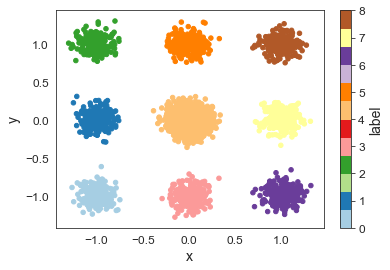

Train Size: (1800, 2)
Test Size: (200,)
Categories: [array([0, 1])]


In [7]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

[3 3 3 ... 2 2 2]
[1 1 1 ... 3 3 3]
[1 1 1 ... 3 3 3]
[2 2 2 ... 3 3 3]
[4 4 4 ... 2 2 2]


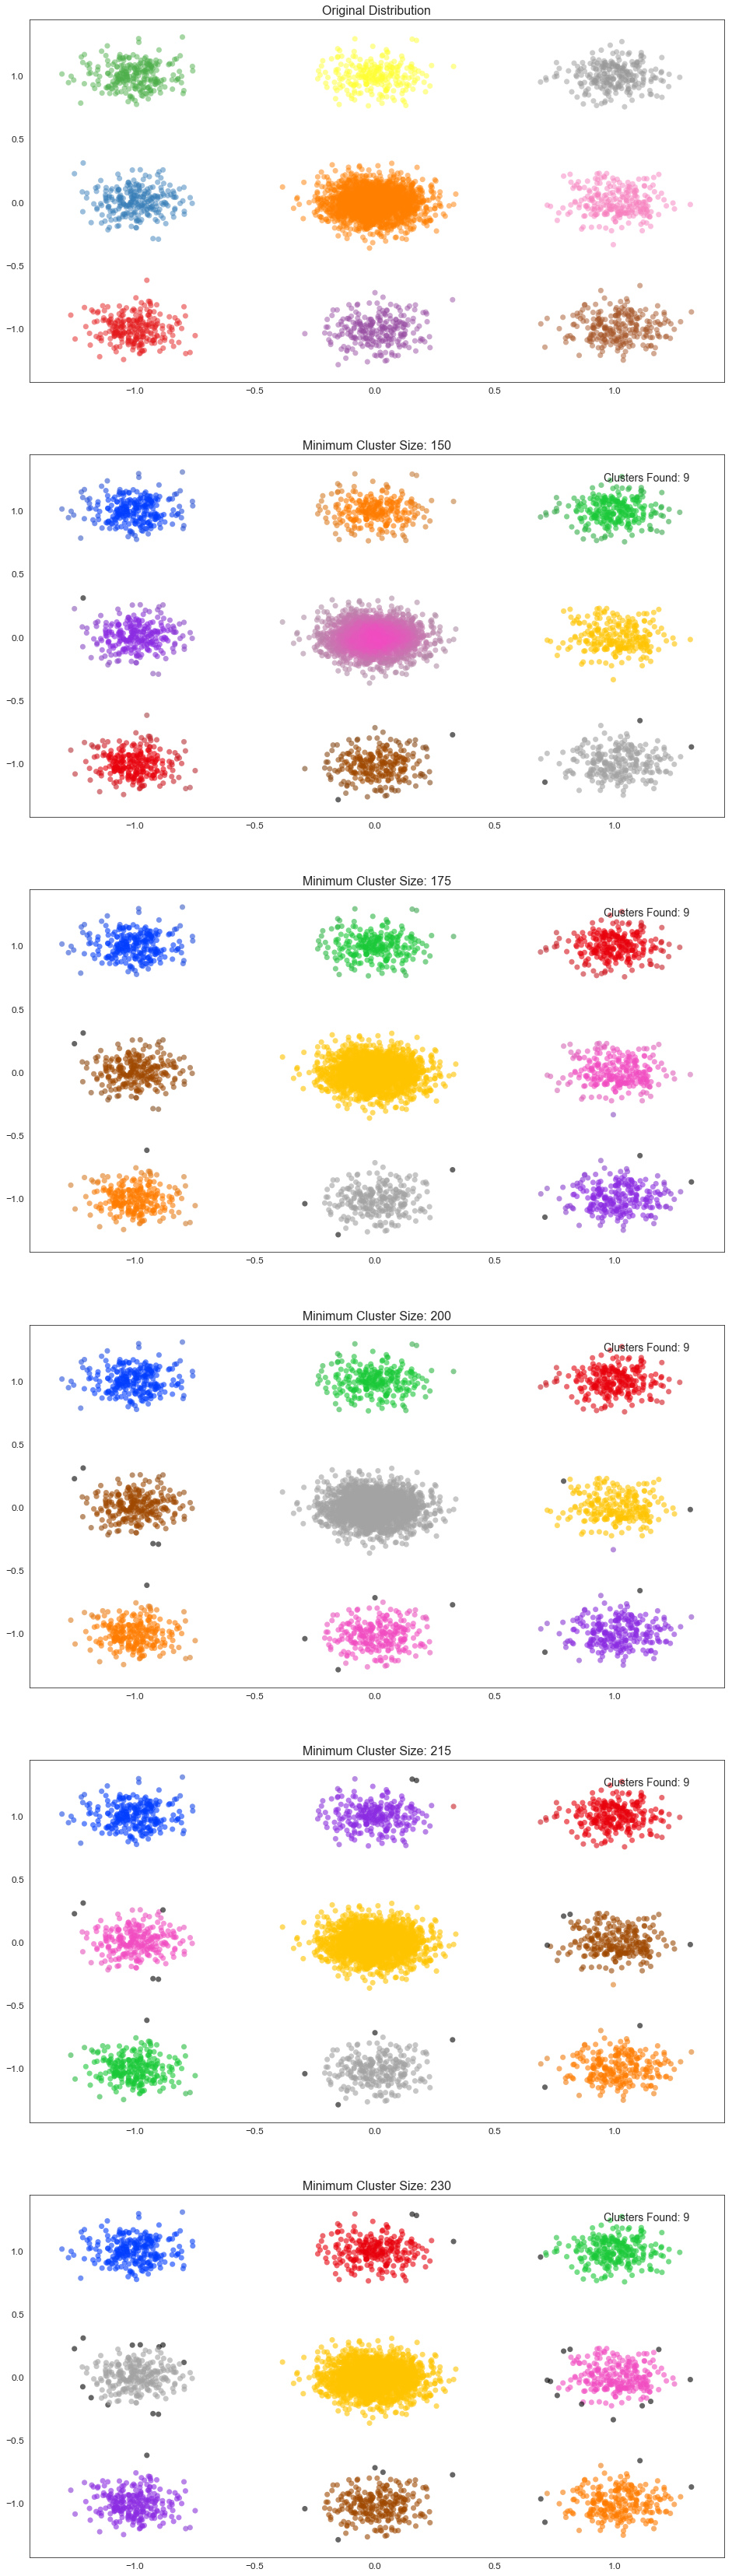

,Clusters,Noise,Silhouette,Halkidi,Kim,Tong
150,9,0.00150,0.799793,0.265310,0.325777,0.278435
175,9,0.00225,0.799035,0.273019,0.433431,0.275829
200,9,0.00325,0.797916,0.270859,0.341537,0.279486
215,9,0.00450,0.795969,0.279564,0.331371,0.307285
230,9,0.00925,0.790588,0.276267,0.346212,0.314310


In [27]:
data = original_data[["x","y"]].values
labels = original_data["label"]
cluster_sizes = [150, 175,200,215, 230]

scores = clusterPerf(data, labels, cluster_sizes)
scores

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e31dcf8>,
      dtype=object)

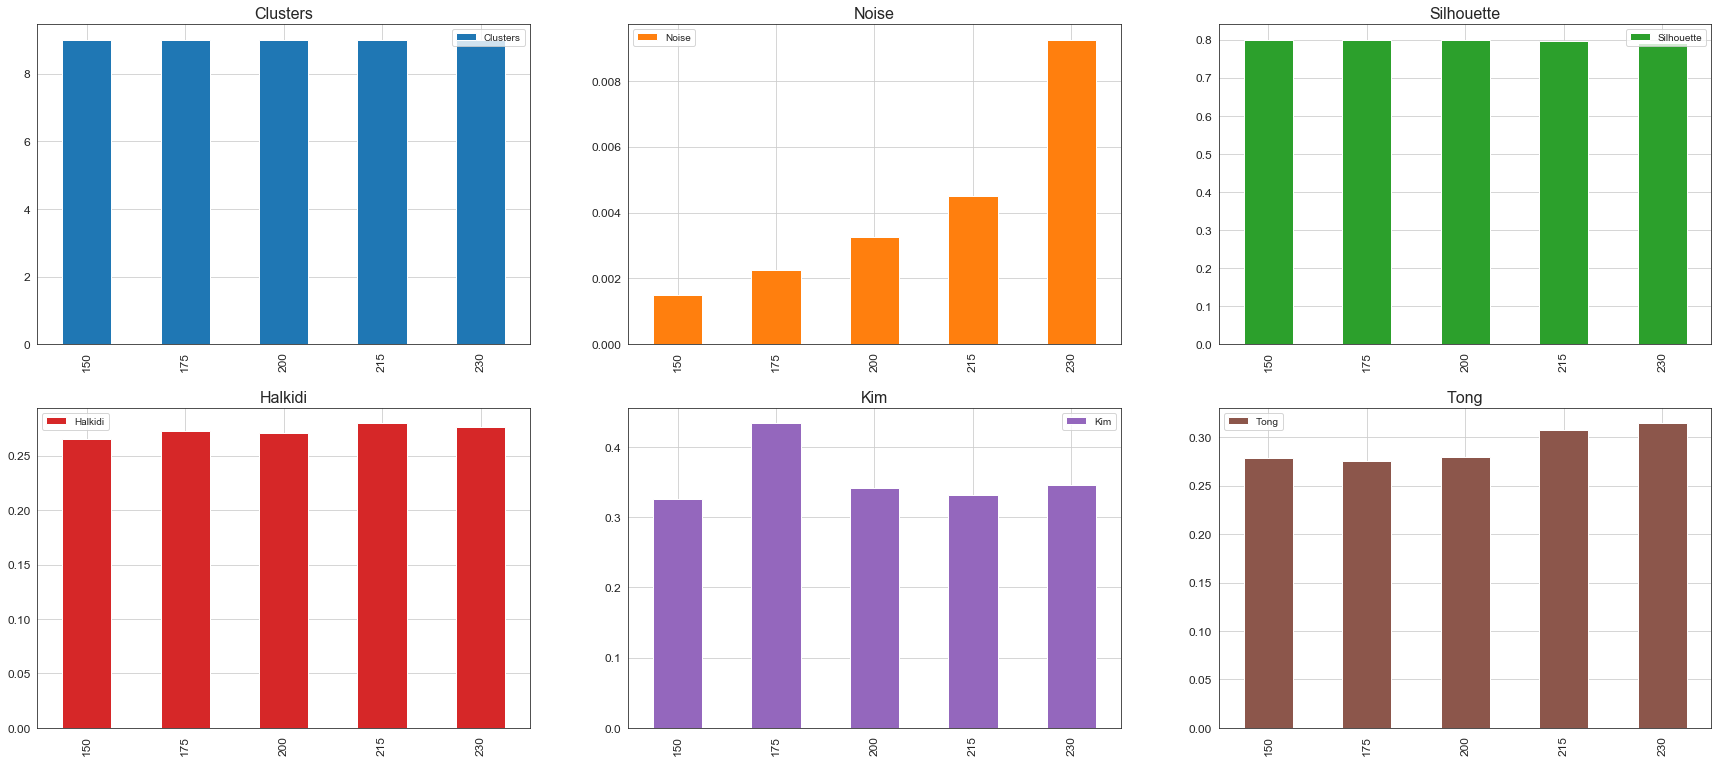

In [28]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(30,20), num="Cluster Scores")
plt.title("Cluster Scores")

scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid=True)

In [10]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [11]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [12]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=20, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 4.96 s, sys: 1.42 s, total: 6.38 s
Wall time: 2.99 s


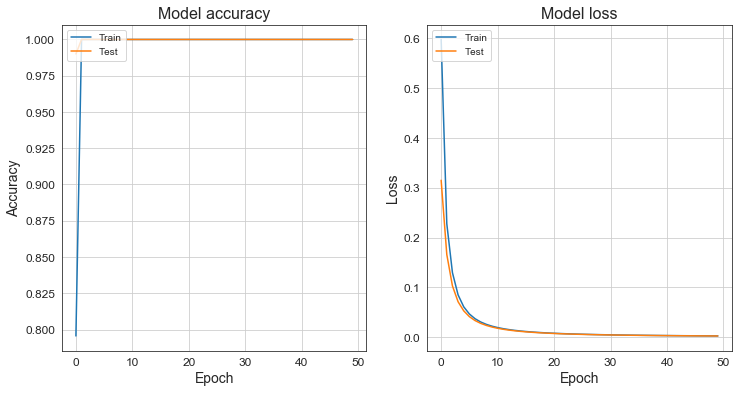

In [13]:
# Plotting results from history
plot_history(history)

## Performing LRP

In [14]:
import innvestigate
import innvestigate.utils as iutils

scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)

all_lrp_E = pd.DataFrame(lrp_E.analyze(all_samples))

Prediction Accuracy
2000/2000 [==============================] - 0s 9us/step
Scores on data set: loss=0.003 accuracy=1.0000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


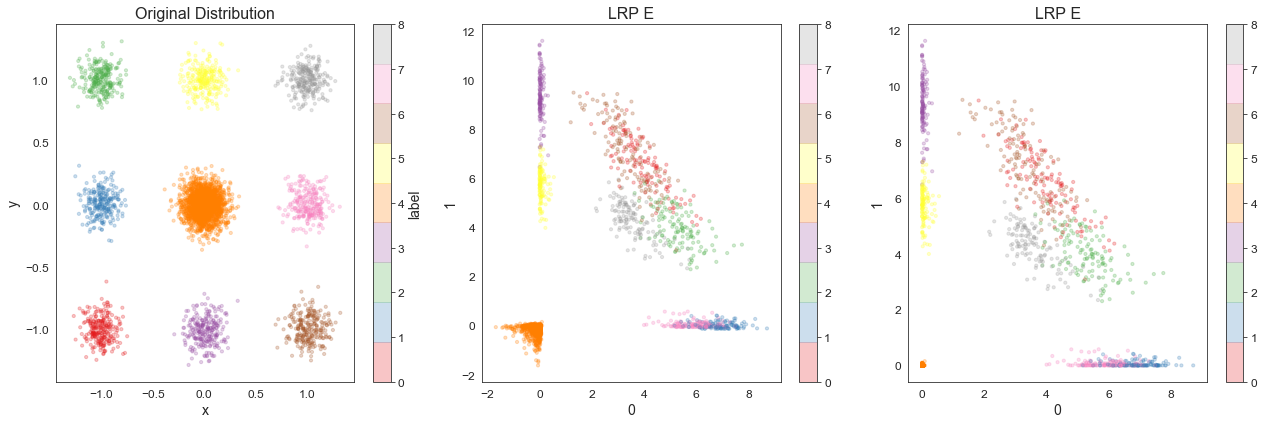

In [15]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}
original_data.plot(ax=axs[0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

# Beginning Clustering using accelerated HDBSCAN*

In [16]:
data = original_data[["x","y"]].values
# original_labels
score_orig = S_Dbw(data, original_labels, centers_id=None, method='Halkidi',
centr='mean', nearest_centr=True, metric='euclidean')
score_orig

0.16098673116687062

In [18]:
# plt.savefig(figures_dir+"clusters_desaturated.png")

# Plotting Clustering Performance

[9 0 9 ... 5 9 1]
[7 0 7 ... 4 7 1]
[0 1 0 ... 0 0 2]
[0 1 0 ... 0 0 2]
[0 1 0 ... 0 0 2]
[0 1 0 ... 0 0 3]
[0 1 0 ... 0 0 2]
[0 1 0 ... 0 0 2]
[0 1 0 ... 0 0 1]


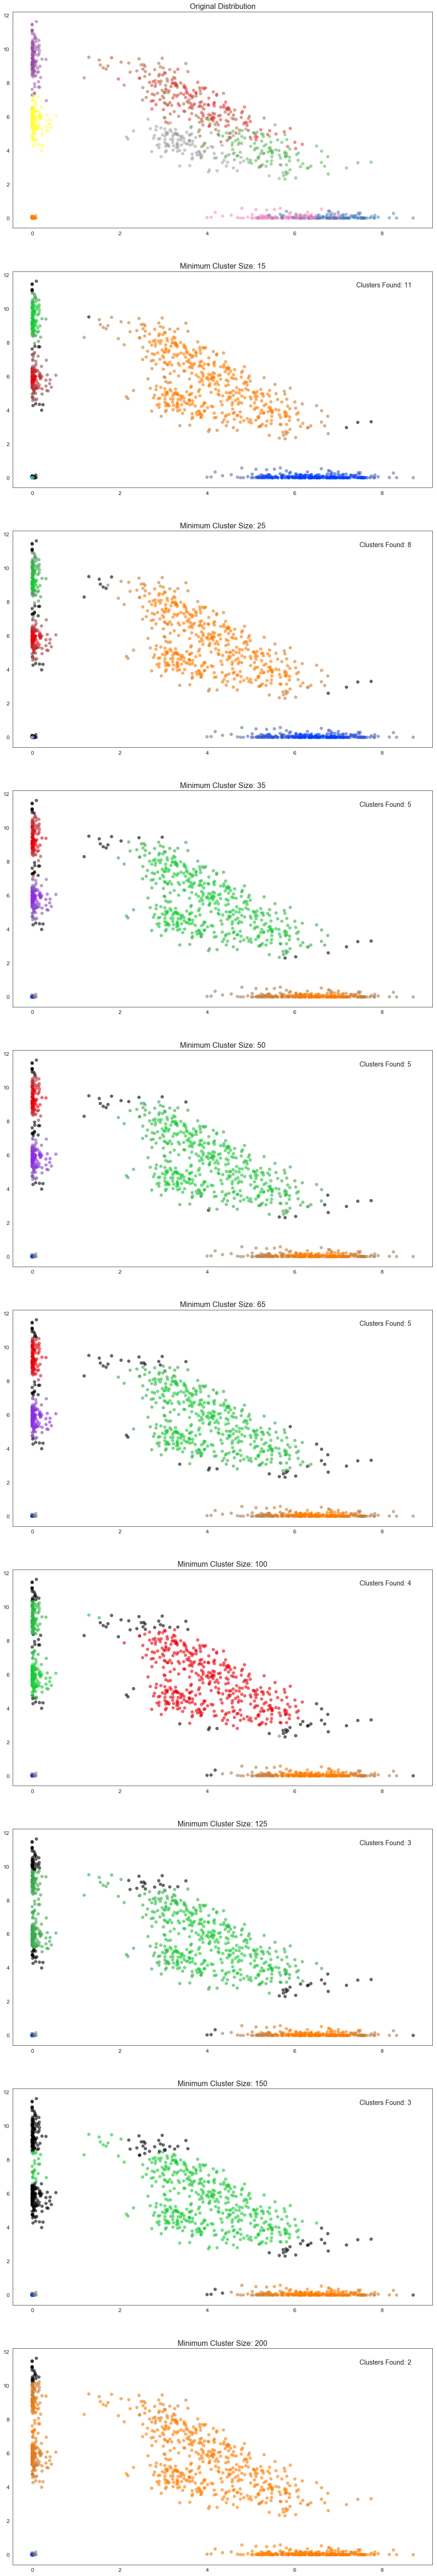

,Clusters,Noise,Silhouette,Halkidi,Kim,Tong
15,11,0.1130,0.541375,0.715976,0.210893,0.221086
25,8,0.1180,0.525197,0.556899,0.262576,0.306758
35,5,0.0210,0.767181,0.350309,0.309200,0.350151
50,5,0.0250,0.766777,0.354288,0.327375,0.355961
65,5,0.0365,0.762005,0.355224,0.338550,0.346260
100,4,0.0470,0.745834,0.522991,0.510149,0.571019
125,3,0.0505,0.682072,0.770232,0.463391,0.576188
150,3,0.1400,0.728967,0.377767,0.302251,0.414113
200,2,0.0110,0.554543,0.368348,0.196029,0.294044


In [29]:
data = pos_lrp[[0,1]].values
labels = pos_lrp["label"]
cluster_sizes = [15,25,35,50,65,100,125,150,200]

scores = clusterPerf(data, labels, cluster_sizes)
scores

In [23]:
# plt.savefig(figures_dir+"cluster_perf_comp.png")

<Figure size 432x288 with 0 Axes>

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1304ec860>,
      dtype=object)

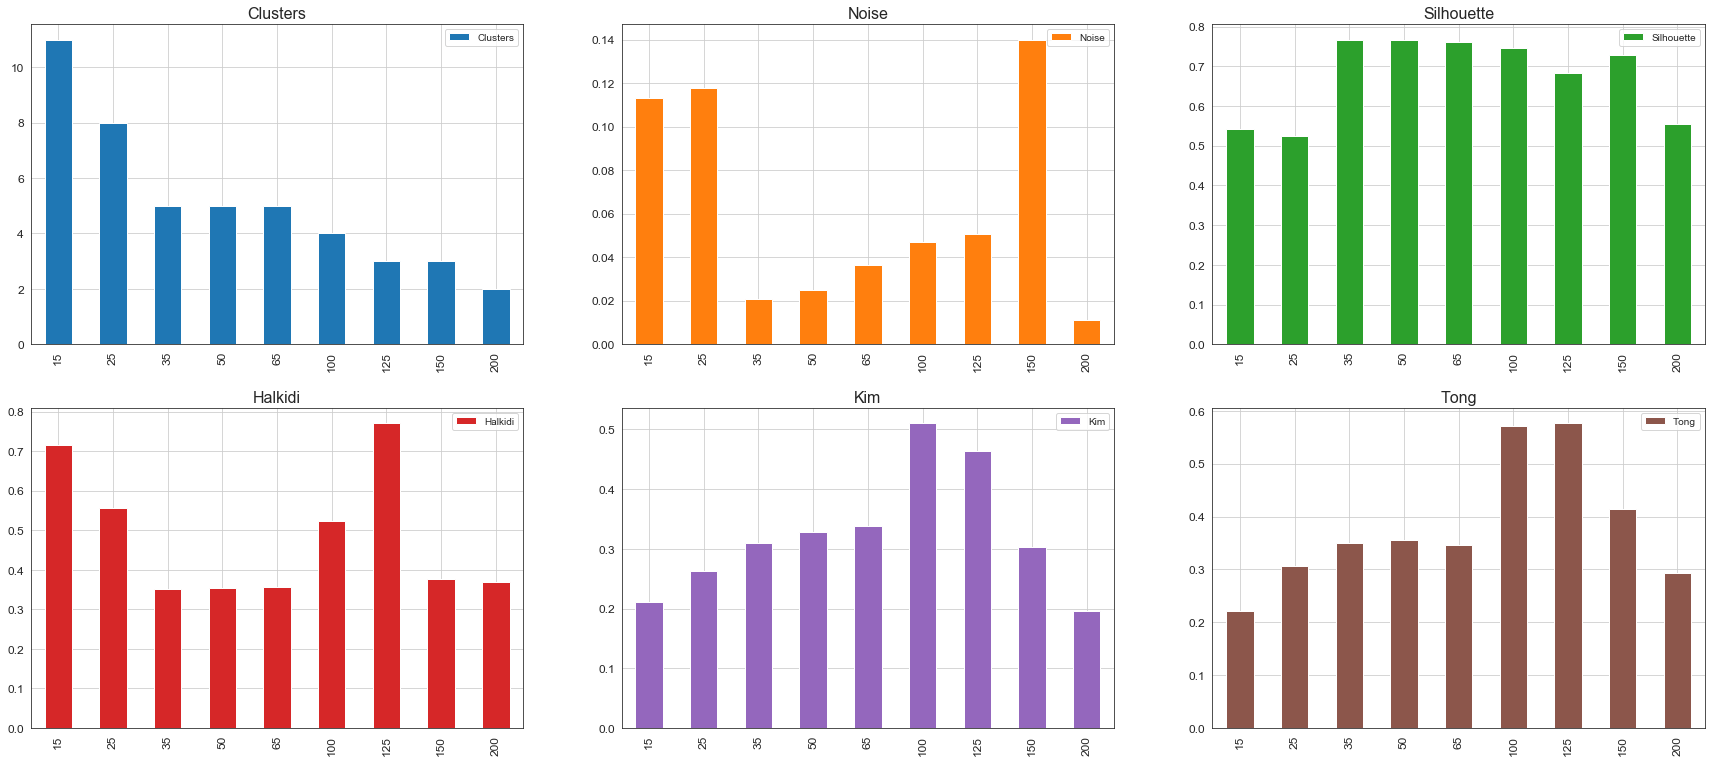

In [30]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(30,20), num="Cluster Scores")
plt.title("Cluster Scores")

scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid=True)

In [25]:
plt.savefig(figures_dir+"cluster_perf_score.png")

<Figure size 432x288 with 0 Axes>

In [31]:
scores.idxmin()

Clusters      200
Noise         200
Silhouette     25
Halkidi        35
Kim           200
Tong           15
dtype: int64

### Halkidi (original S_Dbw) Performs Best!